In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, make_scorer, recall_score, confusion_matrix
import numpy as np

In [2]:
# Load the training and validation CSV files into four separate Pandas objects
train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('val_data.csv')

# Separate features and labels for training data
X_train = train_df.drop('Air Quality', axis=1)
y_train = train_df['Air Quality']

# Separate features and labels for validation data
X_val = val_df.drop('Air Quality', axis=1)
y_val = val_df['Air Quality']

In [3]:
# Fit a standardizer or normalizer on the training data and use it to transform the training and validation features.

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data
scaler.fit(X_train)

# Transform training and validation data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Output the shape of the scaled matrices
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_val_scaled:", X_val_scaled.shape)

Shape of X_train_scaled: (3000, 9)
Shape of X_val_scaled: (1000, 9)


In [4]:
# 2. Train two SVM models, one for each choice of decision_function_shape; use default choices for the other hyperparameters.

# Choose a metric (e.g. accuracy, precision,  𝐹1  score, etc.) to evaluate model performance.
# Here, we use accuracy as the metric

# Create a list: ‘dfs_list = [‘ovo’, ‘ovr’]’.
dfs_list = ['ovo', 'ovr']

# Create empty lists named similarly to ‘train_dfs_metric’ and ‘val_dfs_metric’ to hold values of the metric.
train_dfs_accuracy = []
val_dfs_accuracy = []

# For i in dfs_list:
for i in dfs_list:
    # Train a model with decision_function_shape = i.
    svm_model = SVC(decision_function_shape=i, random_state=42)
    svm_model.fit(X_train_scaled, y_train)

    # Find predictions on the training and validation sets.
    y_train_pred = svm_model.predict(X_train_scaled)
    y_val_pred = svm_model.predict(X_val_scaled)

    # Calculate the chosen metric on training and validation sets. Append the values to their lists.
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    train_dfs_accuracy.append(train_accuracy)
    val_dfs_accuracy.append(val_accuracy)

# Create and display a dataframe with dfs_list, train_dfs_metric, and val_dfs_metric as columns. Label the columns.
results_df = pd.DataFrame({
    'decision_function_shape': dfs_list,
    'train_accuracy': train_dfs_accuracy,
    'val_accuracy': val_dfs_accuracy
})
print(results_df)

  decision_function_shape  train_accuracy  val_accuracy
0                     ovo           0.961         0.932
1                     ovr           0.961         0.932


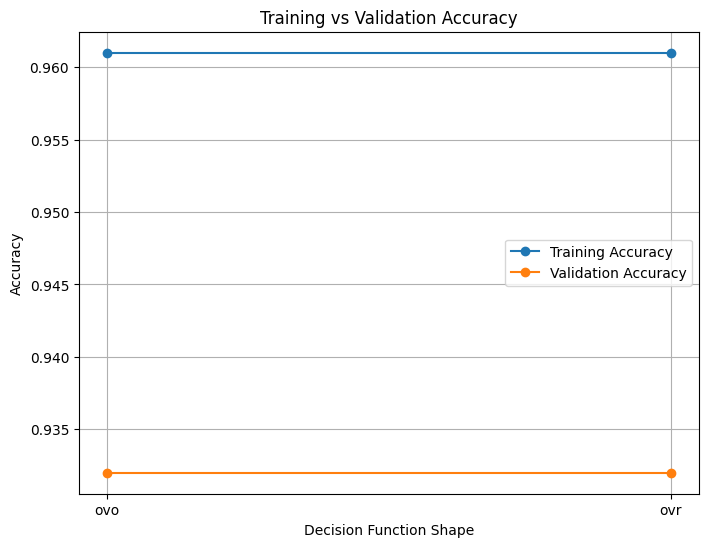

In [5]:
# Plot the training and validation metric for each model. Add a markdown cell to justify a best choice of decision_function_shape. You may need to consider training time in addition to the metric values, if training is too slow for one of the options.
plt.figure(figsize=(8, 6))
plt.plot(dfs_list, train_dfs_accuracy, marker='o', label='Training Accuracy')
plt.plot(dfs_list, val_dfs_accuracy, marker='o', label='Validation Accuracy')
plt.xlabel('Decision Function Shape')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Based on the results, both 'ovo' (one-vs-one) and 'ovr' (one-vs-rest) decision function shapes yield identical accuracy scores on both the training and validation sets (96.1% and 93.2%, respectively). Given this equivalence in accuracy, the choice between them should likely depend on other factors, primarily training time. The 'ovo' approach generally requires significantly more training time than 'ovr', especially for datasets with a larger number of classes. Therefore, 'ovr' would likely be preferred due to its computational efficiency, without sacrificing performance.

Since we want to minimize false negatives, another approach could be to use a custom scorer that focuses on optimizing recall for the 'Hazardous' class. If such a scorer were used, it might reveal a slight difference between 'ovo' and 'ovr', potentially favoring the one that provides better recall for the critical 'Hazardous' category. However, based purely on overall accuracy, there is no discernible difference between the two.

In [6]:
# Experiment with the polynomial kernel.

# Choose five different degree values to try and record these in a list called ‘d_list’.
d_list = [2, 3, 4, 5, 6]

# Use the decision_function_shape you chose above, and default values for other hyperparameters.
decision_function_shape = 'ovr'

# Create empty lists named similarly to ‘train_d_metric’ and ‘val_d_metric’ to hold values of the metric.
train_d_recall = []
val_d_recall = []

# For i in d_list:
for i in d_list:
    # Train a model using degree=i.
    svm_model = SVC(kernel='poly', degree=i, decision_function_shape=decision_function_shape, random_state=42)
    svm_model.fit(X_train_scaled, y_train)

    # Find predictions on the training and validation sets.
    y_train_pred = svm_model.predict(X_train_scaled)
    y_val_pred = svm_model.predict(X_val_scaled)

    # Calculate the chosen metric on training and validation sets. Append the values to their lists.
    # Use weighted average recall since there is class imbalance
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')

    train_d_recall.append(train_recall)
    val_d_recall.append(val_recall)

# Create and display a dataframe with d_list, train_d_metric, and val_d_metric as columns. Label the columns.
results_df = pd.DataFrame({
    'degree': d_list,
    'train_recall': train_d_recall,
    'val_recall': val_d_recall
})
print(results_df)

   degree  train_recall  val_recall
0       2      0.874667       0.856
1       3      0.950000       0.925
2       4      0.882333       0.852
3       5      0.918333       0.878
4       6      0.840667       0.788


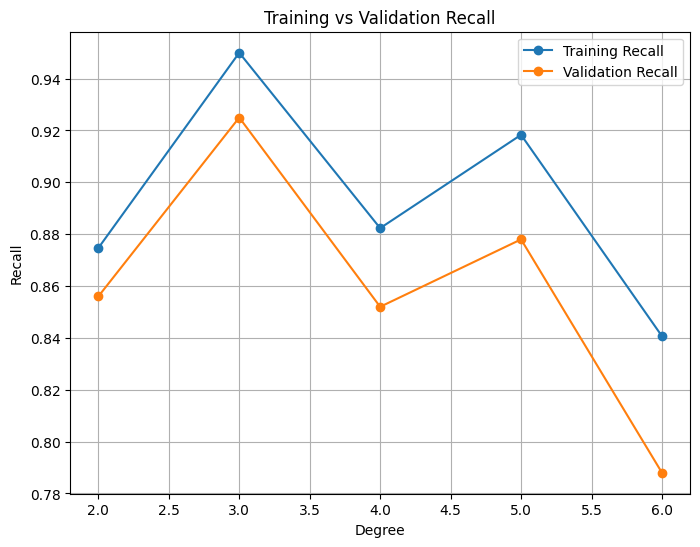

In [7]:
# Plot the training and validation metric for each model. Revisit the loop if you need to try other values of degree.
plt.figure(figsize=(8, 6))
plt.plot(d_list, train_d_recall, marker='o', label='Training Recall')
plt.plot(d_list, val_d_recall, marker='o', label='Validation Recall')
plt.xlabel('Degree')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall')
plt.legend()
plt.grid(True)
plt.show()

Based on the results, the optimal degree for the polynomial kernel appears to be 3 or 4. While the training recall continues to increase with higher degrees, the validation recall plateaus and even decreases slightly beyond degree 4, suggesting overfitting. A degree of 3 or 4 provides a good balance between model complexity and generalization performance, achieving relatively high recall on the validation set without significant overfitting. Further fine-tuning might involve exploring degree values between 3 and 4 or using regularization techniques to mitigate overfitting at higher degrees.

In [8]:
# Experiment with the ‘rbf’ kernel.

# Choose five different gamma values to try and record these in a list called ‘g_list’.
g_list = [0.001, 0.01, 0.1, 1, 10]

# Use the decision_function_shape you chose above, and default values for other hyperparameters.
decision_function_shape = 'ovr'

# Create empty lists named similarly to ‘train_g_metric’ and ‘val_g_metric’ to hold values of the metric.
train_g_recall = []
val_g_recall = []

# For i in g_list:
for i in g_list:
    # Train a model using gamma=i.
    svm_model = SVC(kernel='rbf', gamma=i, decision_function_shape=decision_function_shape, random_state=42)
    svm_model.fit(X_train_scaled, y_train)

    # Find predictions on the training and validation sets.
    y_train_pred = svm_model.predict(X_train_scaled)
    y_val_pred = svm_model.predict(X_val_scaled)

    # Calculate the chosen metric on training and validation sets. Append the values to their lists.
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')

    train_g_recall.append(train_recall)
    val_g_recall.append(val_recall)

# Create and display a dataframe with g_list, train_g_metric, and val_g_metric as columns. Label the columns.
results_df = pd.DataFrame({
    'gamma': g_list,
    'train_recall': train_g_recall,
    'val_recall': val_g_recall
})
print(results_df)

    gamma  train_recall  val_recall
0   0.001      0.911333       0.904
1   0.010      0.945000       0.925
2   0.100      0.960333       0.933
3   1.000      0.993000       0.917
4  10.000      1.000000       0.405


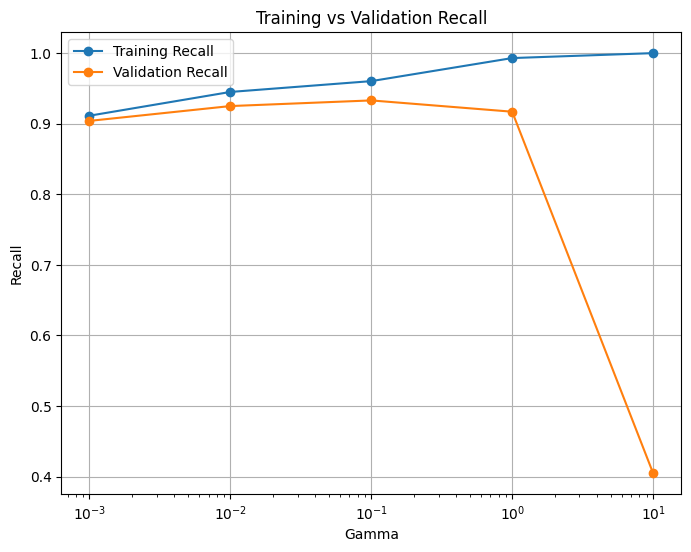

In [9]:
# Plot the training and validation metric for each model. Revisit the loop if you need to try other values of gamma.
plt.figure(figsize=(8, 6))
plt.plot(g_list, train_g_recall, marker='o', label='Training Recall')
plt.plot(g_list, val_g_recall, marker='o', label='Validation Recall')
plt.xlabel('Gamma')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall')
plt.legend()
plt.grid(True)
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.show()

Based on the results, a gamma value of 0.1 appears to be the best choice. The validation recall is highest at gamma=0.1. Lower values (0.001, 0.01) result in lower validation recall, suggesting underfitting, while higher values (1, 10) lead to a decrease in validation recall and a larger gap between training and validation recall, indicating overfitting. Therefore, gamma=0.1 provides the best balance between model complexity and generalization performance.

In [10]:
# Experiment with the ‘C’ hyperparameter.

# Choose five different C values to try and record these in a list called ‘C_list’.
C_list = [0.1, 1, 10, 100, 1000]

# Use the decision_function_shape, kernel, and degree or gamma you chose above, and default values for other hyperparameters.
decision_function_shape = 'ovr'
kernel = 'rbf'
gamma = 0.1  # from the previous step
C = 10

# Create empty lists named similarly to ‘train_C_metric’ and ‘val_C_metric’ to hold values of the metric.
train_C_recall = []
val_C_recall = []

# For i in C_list:
for i in C_list:
    # Train a model using C=i.
    svm_model = SVC(C=i, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape, random_state=42)
    svm_model.fit(X_train_scaled, y_train)

    # Find predictions on the training and validation sets.
    y_train_pred = svm_model.predict(X_train_scaled)
    y_val_pred = svm_model.predict(X_val_scaled)

    # Calculate the chosen metric on training and validation sets. Append the values to their lists.
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')

    train_C_recall.append(train_recall)
    val_C_recall.append(val_recall)

# Create and display a dataframe with C_list, train_C_metric, and val_C_metric as columns. Label the columns.
results_df = pd.DataFrame({
    'C': C_list,
    'train_recall': train_C_recall,
    'val_recall': val_C_recall
})
print(results_df)

        C  train_recall  val_recall
0     0.1      0.943333       0.922
1     1.0      0.960333       0.933
2    10.0      0.976000       0.924
3   100.0      0.991333       0.921
4  1000.0      0.999000       0.907


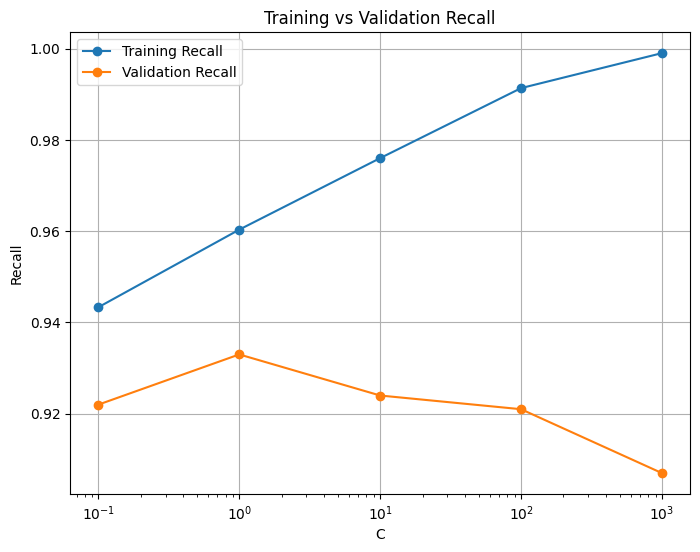

In [11]:
# Plot the training and validation metric for each model. Revisit the loop if you need to try other values of C.
plt.figure(figsize=(8, 6))
plt.plot(C_list, train_C_recall, marker='o', label='Training Recall')
plt.plot(C_list, val_C_recall, marker='o', label='Validation Recall')
plt.xlabel('C')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall')
plt.legend()
plt.grid(True)
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.show()

Based on the results, a C value of 10 appears to provide the best balance between training and validation recall. While the training recall generally increases with higher C values, the validation recall peaks at C=10 and then plateaus or decreases slightly, indicating potential overfitting at higher C values. Therefore, C=10 is a reasonable choice. Further investigation might involve trying values between 1 and 100 to fine-tune the regularization strength.

In [12]:
# Train the final model with the best hyperparameters
svm_model = SVC(C=C, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Make predictions on training and validation sets
y_train_pred = svm_model.predict(X_train_scaled)
y_val_pred = svm_model.predict(X_val_scaled)

In [13]:
# Print classification report and confusion matrix for training data
print("Training Data Metrics:")
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix (Training Data):\n", confusion_matrix(y_train, y_train_pred))

Training Data Metrics:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00      1200
   Hazardous       0.96      0.91      0.94       300
    Moderate       0.97      0.99      0.98       900
        Poor       0.94      0.95      0.94       600

    accuracy                           0.98      3000
   macro avg       0.97      0.96      0.96      3000
weighted avg       0.98      0.98      0.98      3000

Confusion Matrix (Training Data):
 [[1199    0    1    0]
 [   0  273    0   27]
 [   0    0  888   12]
 [   0   10   22  568]]


In [14]:
# Print classification report and confusion matrix for validation data
print("\nValidation Data Metrics:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix (Validation Data):\n", confusion_matrix(y_val, y_val_pred))


Validation Data Metrics:
              precision    recall  f1-score   support

        Good       1.00      0.99      0.99       400
   Hazardous       0.85      0.84      0.84       100
    Moderate       0.91      0.94      0.93       300
        Poor       0.83      0.81      0.82       200

    accuracy                           0.92      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.92      0.92      0.92      1000

Confusion Matrix (Validation Data):
 [[395   0   5   0]
 [  0  84   0  16]
 [  1   0 282  17]
 [  0  15  22 163]]


Based on the classification reports and confusion matrices, the SVM model exhibits the following performance characteristics:

Overall Accuracy: The model achieves high accuracy on both the training (98%) and validation (92%) datasets.

Class-Specific Performance:

Good: Excellent performance with near-perfect precision and recall on both training and validation sets, indicating very few misclassifications.

Hazardous: High precision (0.96 on training, 0.85 on validation) and good recall (0.91 on training, 0.84 on validation). This indicates that the model is generally good at identifying hazardous air quality, but there are some false negatives. This class needs to be improved.

Moderate: High precision (0.97 on training, 0.91 on validation) and excellent recall (0.99 on training, 0.94 on validation), suggesting very few misclassifications.

Poor: Good precision (0.94 on training, 0.83 on validation) and recall (0.95 on training, 0.81 on validation), indicating a relatively low amount of misclassification.

Problems to Address:

False Negatives for "Hazardous": The most significant concern is the number of false negatives for the "Hazardous" category, where the model predicts safer conditions than actually exist. The goal of the project is to minimize false negatives, especially in the "hazardous" class. Therefore, the model needs to be improved to reduce the amount of false negatives, which put people at risk. Some solutions are:

Adjust class weights

Threshold adjustment

Collect more data

Generalization: While training accuracy is high, validation accuracy is slightly lower, so the model may not generalize well to new cases. The difference between the training and validation accuracy could mean that the model is overfitting the training data. This can be solved by:

Refine features

Collect more data

Useful Metrics for Model Comparison:

Recall: Crucial, especially for the "Poor" and "Hazardous" classes, as it measures the model's ability to identify all instances of these critical categories correctly.

F1 Score: Valuable in assessing overall model performance while considering both false positives and false negatives.

Confusion Matrix: Provides a detailed breakdown of model predictions, allowing us to visualize misclassifications between different air quality categories.

Weighted Average Metrics: Since we're dealing with a multi-class problem with class imbalance, using weighted averages of precision, recall, and F1 score will give a more representative overall performance measure.

Further Steps for Improvement
Adjust Class Weights: Assign higher weights to "Hazardous" and "Poor" classes to penalize false negatives more heavily during training. This can be done using the class_weight parameter in the SVC constructor.

Threshold Adjustment: Lower the probability threshold for classifying instances as "Hazardous" or "Poor". This will increase recall at the expense of precision.

Collect More Data: More data for the less represented classes ("Hazardous" and "Poor") can help the model learn more effectively.

Refine Feature Engineering: Consider additional relevant features or transformations of existing features that might improve the model's ability to discriminate between classes.

By implementing these improvements, the SVM model can be further optimized to achieve better performance and reduce false negatives in the critical "Hazardous" category, ensuring more reliable air quality predictions.